In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.makedirs("data", exist_ok=True)

In [3]:
conn = sqlite3.connect("data/oee_industrial.db")


In [4]:
print("Base de datos creada en:", conn.execute("SELECT name FROM sqlite_master LIMIT 1").fetchone())
conn.close()

Base de datos creada en: ('df_prod',)


In [5]:
#Reading CSV

df_prod = pd.read_csv("data/produccion.csv")

In [6]:
#Connect and load table

conn = sqlite3.connect("data/oee_industrial.db")
df_prod.to_sql("produccion", conn, if_exists="replace", index=False)

#Confirm

cursor = conn.execute("SELECT COUNT(*) FROM produccion;")
print("Filas insertadas en tabla 'produccion':",cursor.fetchone()[0])

conn.close()

Filas insertadas en tabla 'produccion': 4


In [7]:
conn = sqlite3.connect("data/oee_industrial.db")
df = pd.read_sql("SELECT * FROM produccion", conn)
print(df)
conn.close()

        fecha turno   linea  prod_real  prod_teorica
0  2025-01-06     A  Linea1        850          1000
1  2025-01-06     B  Linea1        920          1000
2  2025-01-07     A  Linea1        780          1000
3  2025-01-07     B  Linea1        950          1000


In [8]:
#Single connection

conn = sqlite3.connect("data/oee_industrial.db")

#Loading the three csv
df_prod = pd.read_csv("data/produccion.csv")
df_paradas = pd.read_csv("data/paradas.csv")
df_defectos = pd.read_csv("data/defectos.csv")

#Load tables
df_prod.to_sql("produccion", conn, if_exists="replace", index=False)
df_paradas.to_sql("paradas", conn, if_exists="replace", index=False)
df_defectos.to_sql("defectos", conn, if_exists="replace", index=False)


#Verify
for tbl in ("produccion", "paradas", "defectos"):
    cursor = conn.execute(f"SELECT COUNT(*) FROM {tbl};")
    print(f"Filas en {tbl}: {cursor.fetchone()[0]} ")

#Close just here
conn.close()

Filas en produccion: 4 
Filas en paradas: 3 
Filas en defectos: 4 


In [9]:
#Calculate OEE (Overall Equipment Effectiveness) measure the actual efficiency
#of a line and is calculated follows:

#OEE = Availabilty x Performance x Quality

#Availability = (Available time - Stop time)/ Available time
#8 hours per shift = 480 minutes

conn = sqlite3.connect("data/oee_industrial.db")

#Availability per shift
query_disp = """
SELECT
   p.fecha, 
   p.turno, 
   480 - COALESCE(SUM(par.tiempo_min),0) AS tiempo_operativo,
   480 AS tiempo_disponible, 
   ROUND((480 - COALESCE(SUM(par.tiempo_min),0)) * 1.0/480, 3) AS disponibilidad
   FROM produccion p
   LEFT JOIN paradas par ON p.fecha = par.fecha AND p.turno = par.turno
   GROUP BY p.fecha, p.turno;
   """

df_disp = pd.read_sql_query(query_disp, conn)
print("Disponibilidad")
print(df_disp)

Disponibilidad
        fecha turno  tiempo_operativo  tiempo_disponible  disponibilidad
0  2025-01-06     A               450                480           0.938
1  2025-01-06     B               465                480           0.969
2  2025-01-07     A               420                480           0.875
3  2025-01-07     B               480                480           1.000


In [10]:
#CALCULATE PERFORMANCE

#FORMULA  Performance =  actual prod / theoric prod

query_rend = """
SELECT 
  fecha, 
  turno,
  SUM(prod_real) AS prod_real,
  SUM(prod_teorica) AS prod_teorica,
  ROUND(SUM(prod_real) * 1.0/SUM(prod_teorica),3) AS rendimiento
  FROM produccion
  GROUP BY fecha, turno;
  """

df_rend = pd.read_sql_query(query_rend, conn)
print("Rendimiento:")
print(df_rend)

Rendimiento:
        fecha turno  prod_real  prod_teorica  rendimiento
0  2025-01-06     A        850          1000         0.85
1  2025-01-06     B        920          1000         0.92
2  2025-01-07     A        780          1000         0.78
3  2025-01-07     B        950          1000         0.95


In [11]:
#CALCULATE QUALITY

#FORMULA Quality = good units/total units

query_calidad = """
SELECT
    d.fecha,
    d.turno,
    SUM(d.unidades_tot) AS unidades_tot,
    SUM(d.unidades_tot - d.defectuosas) AS unidades_buenas,
    ROUND(SUM(d.unidades_tot - d.defectuosas) * 1.0/SUM(d.unidades_tot), 3) AS calidad
    FROM defectos d
    GROUP BY d.fecha, d.turno;
    """
df_calidad = pd.read_sql_query(query_calidad, conn)
print("Calidad:")
print(df_calidad)

Calidad:
        fecha turno  unidades_tot  unidades_buenas  calidad
0  2025-01-06     A           850              830    0.976
1  2025-01-06     B           920              905    0.984
2  2025-01-07     A           780              750    0.962
3  2025-01-07     B           950              940    0.989


In [12]:
#Put everything together and calculate OEE

query_oee = """
SELECT
    disp.fecha,
    disp.turno,
    disp.disponibilidad,
    rend.rendimiento,
    cal.calidad,
    ROUND(disp.disponibilidad * rend.rendimiento * cal.calidad, 3) AS oee
    FROM (
        SELECT
            p.fecha,
            p.turno,
            ROUND((480 - COALESCE(SUM(par.tiempo_min), 0)) * 1.0/480, 3) AS disponibilidad
            FROM produccion p
            LEFT JOIN paradas par ON p.fecha = par.fecha AND p.turno = par.turno
            GROUP BY p.fecha, p.turno
    ) disp
    JOIN (
        SELECT
            fecha,
            turno,
            ROUND(SUM(prod_real)*1.0 /SUM(prod_teorica), 3) AS rendimiento
            FROM produccion
            GROUP BY fecha, turno
    ) rend ON disp.fecha = rend.fecha AND disp.turno = rend.turno
    JOIN (
        SELECT
            fecha,
            turno,
            ROUND(SUM(unidades_tot - defectuosas)* 1.0/ SUM(unidades_tot), 3) AS calidad
            FROM defectos
            GROUP BY fecha, turno
    ) cal ON disp.fecha = cal.fecha AND disp.turno = cal.turno;
    """

df_oee = pd.read_sql_query(query_oee, conn)
print("OEE por turno:")
print(df_oee)

conn.close()

OEE por turno:
        fecha turno  disponibilidad  rendimiento  calidad    oee
0  2025-01-06     A           0.938         0.85    0.976  0.778
1  2025-01-06     B           0.969         0.92    0.984  0.877
2  2025-01-07     A           0.875         0.78    0.962  0.657
3  2025-01-07     B           1.000         0.95    0.989  0.940


In [13]:
import matplotlib.pyplot as plt

df_oee["fecha_turno"] = df_oee["fecha"] + " " + df_oee["turno"]

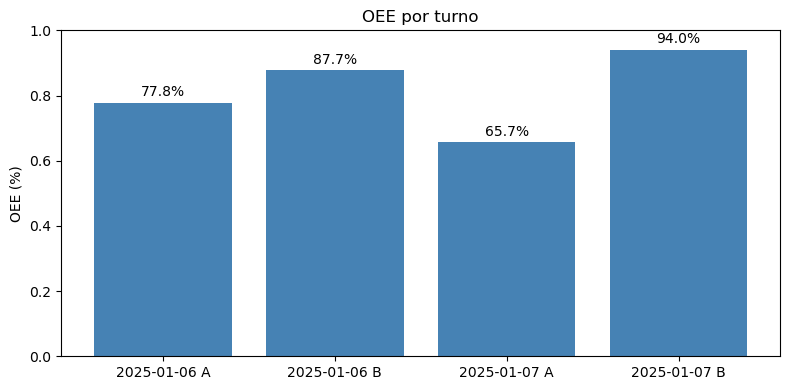

In [14]:
plt.figure(figsize=(8, 4))
plt.bar(df_oee["fecha_turno"], df_oee["oee"], color="steelblue")
plt.title("OEE por turno")
plt.ylabel("OEE (%)")
plt.ylim(0, 1)
for i, v in enumerate(df_oee["oee"]):
    plt.text(i, v + 0.02, f"{v:.1%}", ha="center")
plt.tight_layout()
plt.savefig("img/oee_barras.png", dpi=300)
plt.show()

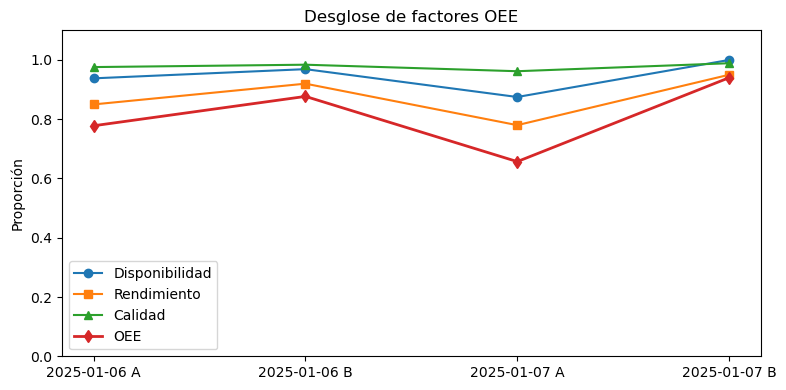

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(df_oee["fecha_turno"], df_oee["disponibilidad"], marker="o", label="Disponibilidad")
plt.plot(df_oee["fecha_turno"], df_oee["rendimiento"], marker="s", label= "Rendimiento")
plt.plot(df_oee["fecha_turno"], df_oee["calidad"], marker="^", label="Calidad")
plt.plot(df_oee["fecha_turno"],df_oee["oee"], marker="d", label="OEE", linewidth=2)
plt.title("Desglose de factores OEE")
plt.ylabel("Proporción")
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.savefig("img/oee_lineas.png", dpi=300)
plt.show()